In [80]:
# Refactoring tips : https://pytorch.org/tutorials/beginner/nn_tutorial.html
# Module forward hook : https://blog.paperspace.com/pytorch-hooks-gradient-clipping-debugging/
# Module, Sequential, and organizing better : https://github.com/FrancescoSaverioZuppichini/Pytorch-how-and-when-to-use-Module-Sequential-ModuleList-and-ModuleDict/blob/master/README.md
# writing your own optimizer http://mcneela.github.io/machine_learning/2019/09/03/Writing-Your-Own-Optimizers-In-Pytorch.html
# torch tensor quick start operatiosn https://jhui.github.io/2018/02/09/PyTorch-Basic-operations/

In [81]:
import os
import torch
from torch import nn
import numpy as np

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

import matplotlib.pyplot as plt

# Dataset

In [82]:
class XORDataset(Dataset):
    """XOR dataset."""

    def __init__(self, num_samples = 200):
        """
        Args:
            num_samples: number of samples to generate
        """

        self.num_samples = num_samples
        self.X = np.random.randint(0,high=2, size=num_samples*2).reshape((num_samples, 2)).astype(np.float32)
        self.y = np.logical_xor(self.X[:,0], self.X[:,1]).reshape((num_samples,1)).astype(np.float32)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        #sample = {'X': self.X[idx], 'y': self.y[idx]}
        sample = (self.X[idx], self.y[idx])

        return sample

# Dataloaders, get_data

In [83]:
def get_data(batch_size):

    datasets = {
        'train' : XORDataset(200),
        'valid' : XORDataset(50),
    }
    loaders = {
    'train' : torch.utils.data.DataLoader(datasets['train'],  
                                          batch_size=batch_size, 
                                          shuffle=True,
                                          num_workers=1),
    'valid' : torch.utils.data.DataLoader(datasets['valid'], 
                                          batch_size=batch_size, 
                                          shuffle=True,
                                          num_workers=1),
    }
    return datasets, loaders
    

# Net model
## class XORnet

In [84]:
class XORnet(nn.Module):

    def __init__(self):
        super(XORnet, self).__init__()

        self.fc1=nn.Linear(2, 2)
        self.sig1=nn.Sigmoid()
        self.fc2=nn.Linear(2, 1)
        self.sig2=nn.Sigmoid()
        
        self.activations=[0 for i in range(3)] # 3 "layers" : input/hidden/output

        # custom weight initialization

        for layer in [self.fc1, self.fc2]:
            nn.init.normal_(layer.weight)


    def forward(self, x):
        '''Forward pass'''
        
        x2 = self.fc1(x)
        x2 = self.sig1(x2)
        x3 = self.fc2(x2)
        x3 = self.sig2(x3)
        self.store_activations(x, x2, x3)
        return x3

    def store_activations(self, x, x2, x3):
        self.activations[0] = x
        self.activations[1] = x2
        self.activations[2] = x3

In [85]:
class learner():

    def __init__(self, model, lr, opt_name, loss_fn=nn.MSELoss()):
        self.model = model
        self.lr = lr
        self.loss_fn = loss_fn
        optimizers = {
            'adam': torch.optim.Adam(model.parameters(), lr = lr) ,
            'SGD': torch.optim.SGD(self.model.parameters(), lr = lr)
        }
        self.opt = optimizers[opt_name]

    def get_model(self):
        return self.model, self.opt, self.loss_fn

In [86]:
# to do : determine learning rate by grid search
'''To make comparisons easier, we use the
same learning rate η for FF+FB and FF, determined by grid search. 
We average 10 runs, taking g = 0.7 and η = 0.025 for both networks. The number of
epochs is capped to 300 epochs. With these constraints, η is optimized (by grid search) for the smallest
number of epochs of the two networks that reached 100% training accuracy in 10 runs.'''

'To make comparisons easier, we use the\nsame learning rate η for FF+FB and FF, determined by grid search. \nWe average 10 runs, taking g = 0.7 and η = 0.025 for both networks. The number of\nepochs is capped to 300 epochs. With these constraints, η is optimized (by grid search) for the smallest\nnumber of epochs of the two networks that reached 100% training accuracy in 10 runs.'

# class statsLogger

In [87]:
class statsLogger():
    def __init__(self):
        self.accuracies=[]   # accuracy for each epoch
        self.losses=[]

    def startEpoch(self):
        self.epoch_total_samples=0
        self.epoch_correct_samples=0
        self.minibatch_losses=[]  # losses for all minibatches in the epoch

    def getMinibatchStats(self, pred, yb, loss, pref_fn=lambda pred : (pred>0.5).float() ):
        #Accuracy
        predicted = pref_fn(pred)
        minibatch_num_corrects = (predicted == yb).float().sum()
        minibatch_total = pred.shape[0]
        minibatch_accuracy = minibatch_num_corrects.item()/pred.shape[0]
        self.epoch_total_samples += minibatch_total
        self.epoch_correct_samples += minibatch_num_corrects.item()
        self.minibatch_losses.append(loss.item())

    def endEpoch(self):
        self.losses.append(np.array(self.minibatch_losses).mean())
        self.accuracies.append(100 * self.epoch_correct_samples / self.epoch_total_samples)
        
    

# function plotTraining

In [88]:
def plotTraining(loggers: list, learner: learner):
    
    fig, axs= plt.subplots(1, 2, figsize=(18, 6))  
    plt.title('XOR Dataset Opt={}, lr={}, loss_fn={}'
        .format(learner.opt.__class__.__name__, learner.lr, learner.loss_fn.__class__.__name__))

    axs[0].plot(loggers['train'].losses, label='Train loss')
    axs[0].plot(loggers['valid'].losses, label='Valid loss')
    axs[0].set_title('Losses')
    axs[0].set_xlabel('epochs')
    axs[0].set_ylabel('loss')

    axs[1].plot(loggers['train'].accuracies, label='Train accuracy')
    axs[1].plot(loggers['valid'].accuracies, label='Valid accuracy')
    axs[1].set_title('Accuracies')  
    axs[1].set_xlabel('epochs')
    axs[1].set_ylabel('loss')

    plt.legend()
    plt.show()

# class ActivationsCollector

In [89]:
class activationsCollector():
    def __init__(self, g, epochs, dataset_size):
        self.g = g
        # 5 because 2 input, 2 hidden layer neurons ad 1 output in perceptron ==> 5 activations to store
        self.neurons={}
        self.targets=[]
        self.num_layers=0

    def collect(self, model, yb):

        bs=yb.size()[0]         # the first dim of the activation tensor or target tensor is the number of samples in minibatch
        self.targets.extend([yb[i].item() for i in range(bs)])

        activations=model.activations
        if self.num_layers==0:
            self.num_layers=len(activations)
                
        for l in range(self.num_layers):

            for neuron in range(activations[l].size()[1]): # the second dimensions of the activations in a layer is the number of neurons in that layer

                neuron_name=f'{l}-{neuron}'
                if (neuron_name not in self.neurons):
                    self.neurons[neuron_name]=[]

                self.neurons[neuron_name].extend([activations[l][i, neuron].item() for i in range(bs)])

# fit() function

In [90]:
def fit(model, optimizer, loaders, epochs, activation_collector):

    trainLogger = statsLogger()
    validLogger = statsLogger()

    for epoch in range(epochs): 

        trainLogger.startEpoch()

        ## training part 
        ##--------------

        model.train()
        for i, (xb, yb) in enumerate(loaders['train']):

            optimizer.zero_grad()

            ## 1. forward propagation
            pred = model(xb)

            # activations
            activation_collector.collect(model, yb)
            
            ## 2. loss calculation
            loss = loss_fn(pred, yb)        
            
            ## 3. backward propagation
            loss.backward()
            
            ## 4. weight optimization
            optimizer.step()

            #logger
            trainLogger.getMinibatchStats(pred, yb, loss)

        trainLogger.endEpoch()
            
        ## evaluation part
        ## ---------------

        with torch.no_grad():  #gradients should not evaluate
            model.eval()
            validLogger.startEpoch()
            for xb, yb in loaders['valid']:
                pred = model(xb)
                loss = loss_fn(pred, yb)

                validLogger.getMinibatchStats(pred, yb, loss)

            validLogger.endEpoch()

    return { 'train' : trainLogger, 'valid' : validLogger }

# TRAINING !!! 

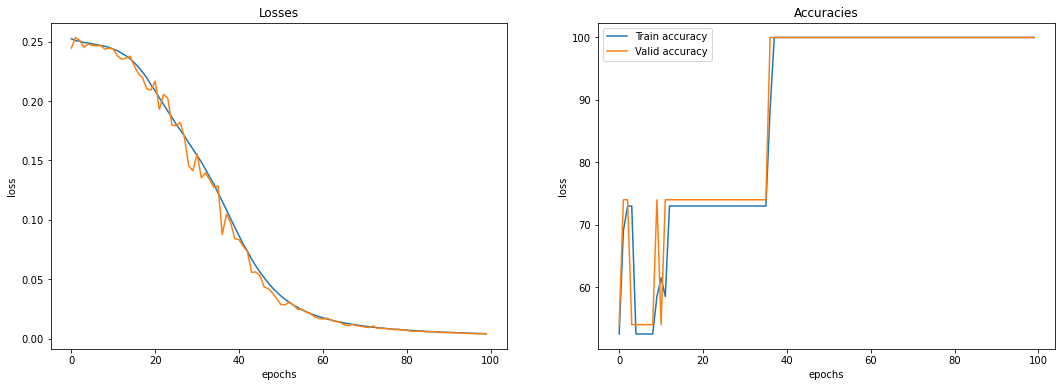

In [130]:
lr = 0.03
bs = 40
datasets, loaders = get_data(bs)
g=0.7
epochs=100

activation_collector=activationsCollector(g, epochs, len(loaders['train'].dataset))
Xorln = learner(XORnet(), lr, 'adam')
model, opt, loss_fn = Xorln.get_model()


loggers = fit(model, opt, loaders, epochs, activation_collector)
plotTraining(loggers, Xorln)

In [92]:
num_neurons=len(activation_collector.neurons.keys())
num_neurons + (num_neurons % 2)

6

In [93]:
print(activation_collector.neurons['1-0'][0])

0.5918013453483582


In [103]:
t0_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.targets[i] == 0]
t1_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.targets[i] == 1]
len(activation_collector.targets)

20000

In [106]:
len(t1_idx)

9700

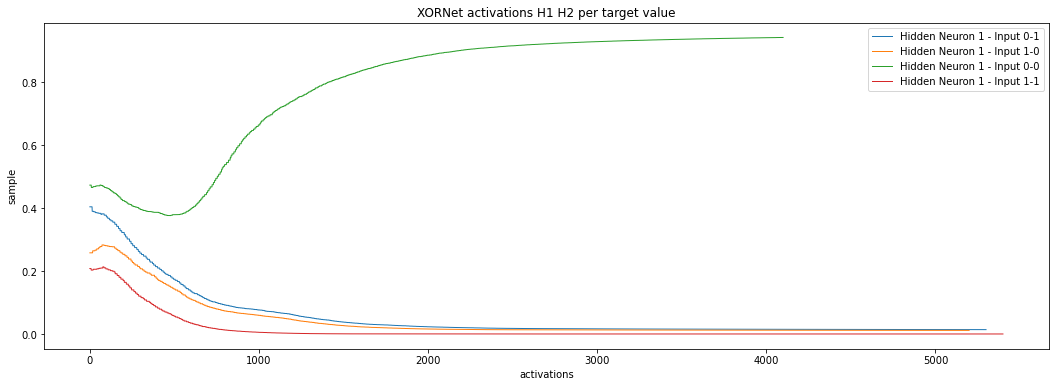

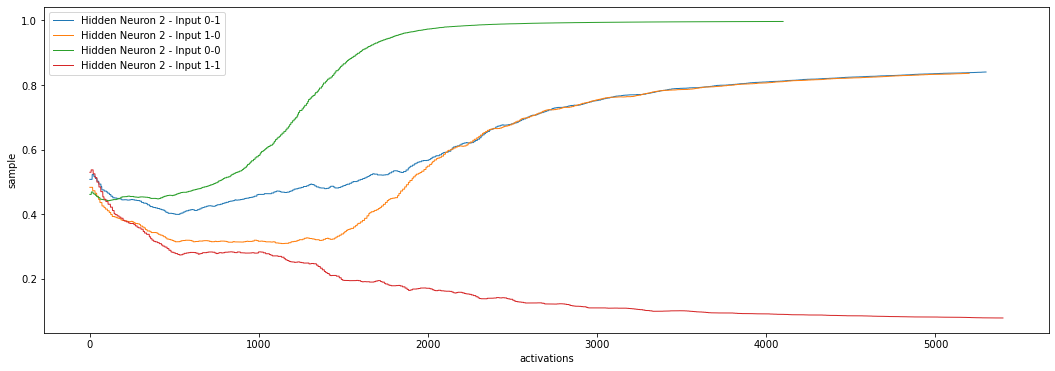

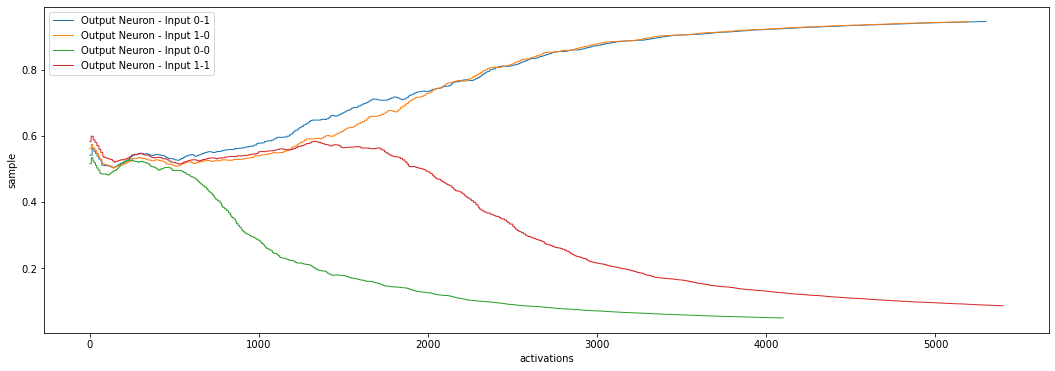

In [136]:
fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
plt.title('XORNet activations H1 H2 per target value')

t0_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.targets[i] == 0]
t1_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.targets[i] == 1]
i01_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.neurons['0-0'][i] == 0 and activation_collector.neurons['0-1'][i] == 1 ]
i10_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.neurons['0-0'][i] == 1 and activation_collector.neurons['0-1'][i] == 0 ]
i00_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.neurons['0-0'][i] == 0 and activation_collector.neurons['0-1'][i] == 0 ]
i11_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.neurons['0-0'][i] == 1 and activation_collector.neurons['0-1'][i] == 1 ]

axs.plot([ activation_collector.neurons['1-0'][i] for i in i01_idx ], linewidth=1, label='Hidden Neuron 1 - Input 0-1')
axs.plot([ activation_collector.neurons['1-0'][i] for i in i10_idx ], linewidth=1, label='Hidden Neuron 1 - Input 1-0')
axs.plot([ activation_collector.neurons['1-0'][i] for i in i00_idx ], linewidth=1, label='Hidden Neuron 1 - Input 0-0')
axs.plot([ activation_collector.neurons['1-0'][i] for i in i11_idx ], linewidth=1, label='Hidden Neuron 1 - Input 1-1')
# axs.plot([ activation_collector.neurons['1-0'][i] for i in t1_idx ],  linewidth=1, label='Hidden Neuron 1 - Target 1')

axs.set_xlabel('activations')
axs.set_ylabel('sample')
plt.legend()
plt.show()

fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
axs.plot([ activation_collector.neurons['1-1'][i] for i in i01_idx ], linewidth=1, label='Hidden Neuron 2 - Input 0-1')
axs.plot([ activation_collector.neurons['1-1'][i] for i in i10_idx ], linewidth=1, label='Hidden Neuron 2 - Input 1-0')
axs.plot([ activation_collector.neurons['1-1'][i] for i in i00_idx ], linewidth=1, label='Hidden Neuron 2 - Input 0-0')
axs.plot([ activation_collector.neurons['1-1'][i] for i in i11_idx ], linewidth=1, label='Hidden Neuron 2 - Input 1-1')

axs.set_xlabel('activations')
axs.set_ylabel('sample')
plt.legend()
plt.show()

fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
axs.plot([ activation_collector.neurons['2-0'][i] for i in i01_idx ], linewidth=1, label='Output Neuron - Input 0-1')
axs.plot([ activation_collector.neurons['2-0'][i] for i in i10_idx ], linewidth=1, label='Output Neuron - Input 1-0')
axs.plot([ activation_collector.neurons['2-0'][i] for i in i00_idx ], linewidth=1, label='Output Neuron - Input 0-0')
axs.plot([ activation_collector.neurons['2-0'][i] for i in i11_idx ], linewidth=1, label='Output Neuron - Input 1-1')

axs.set_xlabel('activations')
axs.set_ylabel('sample')
plt.legend()
plt.show()

(0.0, 1.0)


Text(0, 0.5, 'sample')

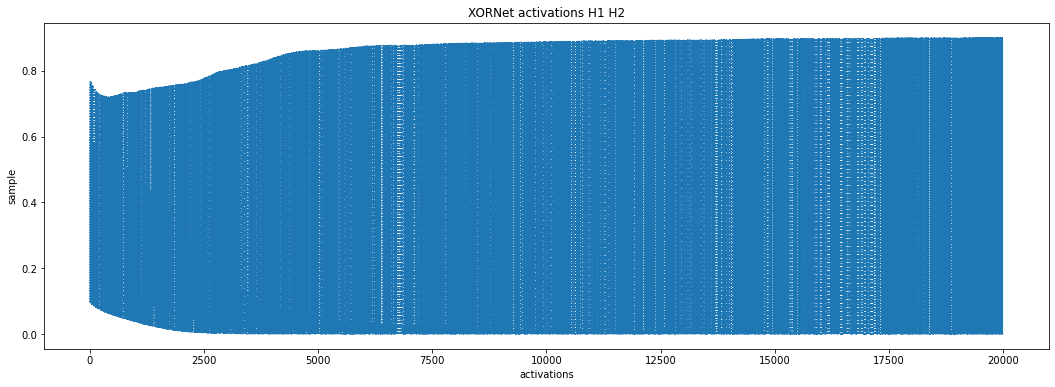

In [100]:
fig, axs= plt.subplotslen(1, 1, figsize=(18, 6))  
plt.title('XORNet activations H1 H2')


axs.plot(activation_collector.neurons['1-0'], linestyle=":", linewidth=1, label='Hidden Neuron 1')

axs.set_xlabel('activations')
axs.set_ylabel('sample')

In [95]:
def plotActivations(collector: activationsCollector):

    num_neurons=len(collector.neurons.keys())
    num_layers=collector.num_layers
    
    fig, axs= plt.subplots(num_layers, 2, figsize=(18, 6* num_layers))  
    plt.title('XORNet activations')

    axs[0].plot(loggers['train'].losses, label='Train loss')
    axs[0].set_title('Losses')
    axs[0].set_xlabel('epochs')
    axs[0].set_ylabel('loss')

    axs[1].plot(loggers['train'].accuracies, label='Train accuracy')
    axs[1].plot(loggers['valid'].accuracies, label='Valid accuracy')
    axs[1].set_title('Accuracies')  
    axs[1].set_xlabel('epochs')
    axs[1].set_ylabel('loss')

    plt.legend()
    plt.show()
    

In [132]:
x_in = torch.tensor([[1.0, 1.0]])

In [134]:
model(x_in)

tensor([[0.0863]], grad_fn=<SigmoidBackward>)

In [98]:
model.activations

[tensor([[0., 1.]]),
 tensor([[1.4812e-07, 9.9992e-01]], grad_fn=<SigmoidBackward>),
 tensor([[0.3282]], grad_fn=<SigmoidBackward>)]

In [99]:
model.layers[2].weight

AttributeError: 'XORnet' object has no attribute 'layers'

In [ ]:
model.layers.fc1.weight, model.layers.fc1.bias

(Parameter containing:
 tensor([[-6.5834, -8.2177],
         [-4.7596, -4.9996]], requires_grad=True),
 Parameter containing:
 tensor([-2.1961], requires_grad=True))

In [ ]:
model.fc2.weight, model.fc2.bias

(Parameter containing:
 tensor([[-5.4566,  6.3949]], requires_grad=True),
 Parameter containing:
 tensor([2.4287], requires_grad=True))

In [ ]:
type(model.fc1)

torch.nn.modules.linear.Linear

# optimizer

http://mcneela.github.io/machine_learning/2019/09/03/Writing-Your-Own-Optimizers-In-Pytorch.html   


In [ ]:
from torch.optim import Optimizer
class SGDWithTE(Optimizer):
    '''
    Implement backpropagation algorithm with a twist
    Using inter-neuron transfer entropy to change the weight update
    Wl:= Wl − η∆l(1 − tel)
    '''